In [3]:
# class activation heatmaps tell which part of a image led the convnet to take its final decision

In [4]:
# CAM visualization: 2d grid of scores associated with an output class, computed for every location in any input image, telling how important each location is for the class under consideration

In [5]:
from keras.models import load_model
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import decode_predictions,VGG16, preprocess_input
import numpy as np
from keras import backend as K
import cv2
import matplotlib.pyplot as plt
import os

2022-12-05 10:13:06.346354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/francoterranova/opt/anaconda3/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/francoterranova/opt/anaconda3/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["dlopen(/Users/francoterranova/opt/anaconda3/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so, 0x0006): symbol not found in flat namespace '__ZN3tsl2io7DirnameENSt3__117basic_string_viewIcNS1_11char_traitsIcEEEE'"]
  warnings.warn(f"unable to load libtensorflow_io_pl

In [13]:
model = VGG16(weights='imagenet')
#model = load_model(os.path.join("..","models","CNN_baseline.h5"))

In [14]:
img_path = os.path.join("..","workspace","images","all","JFr.2022.03.20.16.35.OD.MP4_3.jpg")
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [15]:
preds = model.predict(x)
print(preds.shape)
# top 3 classes predicted for the image
print('Predicted:', decode_predictions(preds, top=3)[0])

/Users/francoterranova/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(1, 1000)
Predicted: [('n01443537', 'goldfish', 0.104181334), ('n09472597', 'volcano', 0.10027222), ('n09229709', 'bubble', 0.024453657)]


In [16]:
# entry maximally activated
np.argmax(preds[0])

1

In [17]:
output = model.output[:, np.argmax(preds[0])]
# last convolutional layer in the architecture
last_conv_layer = model.get_layer('block5_conv3')

In [18]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# weight every channel of the output feature map by the gradient of the maximally activated class with respect to the channel
grads = K.gradients(output, last_conv_layer.output)[0]

# vector where each entry is the mean intensity of the gradient over a specific feature-map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

# multiply each channel depending on how important it is wrt to the target class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# channel-wise mean of the resulting feature map in the heatmap of the class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

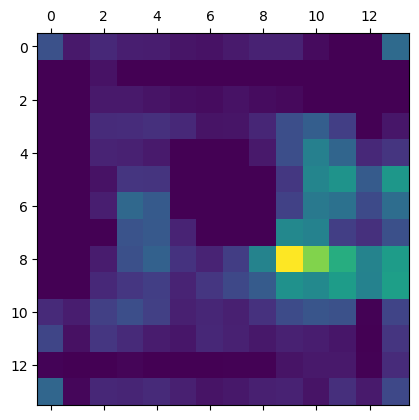

In [19]:
# normalize the heatmap between 0 and 1 for visualization purposes
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [21]:
# superimpose the original image
heatmap_intensity_factor = 0.05
img = cv2.imread(img_path)

# resize the heatmap to be the same size of the image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * heatmap_intensity_factor + img
cv2.imwrite('result.jpg', superimposed_img)

True